 # **Image Classification (Cats vs Dogs)**
 ## Part 2 - Transfer Learning

![](./woof_meow.jpg)

# **What Is Transfer Learning?**

In deep learning, transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. One or more layers from the trained model are then used in a new model trained on the problem of interest.

# **Models for Transfer Learning:**

There are perhaps a dozen or more top-performing models for image recognition that can be downloaded and used as the basis for image recognition and related computer vision tasks.

Perhaps three of the more popular models are as follows:

* VGG (e.g. VGG16 or VGG19).

* GoogLeNet (e.g. InceptionV3).

* Residual Network (e.g. ResNet50).

These models are both widely used for transfer learning both because of their performance, but also because they were examples that introduced specific architectural innovations, namely consistent and repeating structures (VGG), inception modules (GoogLeNet), and residual modules (ResNet).

# Import libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import math
import zipfile
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

# Preparing Train and TestData 
(Converting Zip data and getting images' names)

In [2]:
# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        temp_dir=os.path.join(dirname, filename)
        if "train" in temp_dir or "test" in temp_dir:
            print(temp_dir)
            with zipfile.ZipFile(temp_dir,"r") as z:
                 z.extractall(".")
                    
DATA_DIR = "/kaggle/working/"
trn_dir = f'{DATA_DIR}train'
tst_dir = f'{DATA_DIR}test'

/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
## getting all the trian and test data names
trn_fnames = glob.glob(f'{trn_dir}/*.*')
tst_fnames = glob.glob(f'{tst_dir}/*.*')
trn_fnames[:5]

['/kaggle/working/train/cat.10835.jpg',
 '/kaggle/working/train/dog.10634.jpg',
 '/kaggle/working/train/dog.6452.jpg',
 '/kaggle/working/train/cat.9230.jpg',
 '/kaggle/working/train/dog.8758.jpg']

## Showing a random sample image

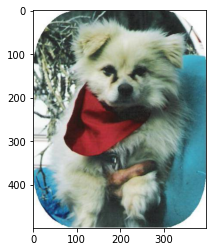

In [4]:
rand_number = random.randint(0,len(trn_fnames))
img = plt.imread(trn_fnames[rand_number])
plt.imshow(img)

## Create Train dataset

In [5]:
size=80

def  create_trainData(path):
    X = []
    y = []
    convert = lambda category : int(category == 'dog')
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p))
        new_img_array = cv2.resize(img_array, dsize=(size,size))
        X.append(new_img_array)
        y.append(category)
    return X, y

X_train,y_train = create_trainData(trn_dir)

In [6]:
X_train = np.array(X_train).reshape(-1, size,size,3)
y_train = np.array(y_train)
X_train.shape

(25000, 80, 80, 3)

# Normalize data

In [7]:
X_train = X_train / 255.0

# Determining Validation data

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# VGG16 

In [15]:
in_sh=X_train.shape[1:]   # (80, 80, 3)

model = VGG16(include_top=False, input_shape=in_sh)

for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1) 

model = Model(inputs=model.inputs, outputs=output)

58892288/58889256 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=10,validation_data=(X_val,y_val))

Epoch 1/10
1675/1675 [==============================] - 371s 221ms/step - loss: 0.4384 - accuracy: 0.7965 - val_loss: 0.3440 - val_accuracy: 0.8416
Epoch 2/10
1675/1675 [==============================] - 369s 220ms/step - loss: 0.3298 - accuracy: 0.8518 - val_loss: 0.3636 - val_accuracy: 0.8308
Epoch 3/10
1675/1675 [==============================] - 369s 220ms/step - loss: 0.3010 - accuracy: 0.8663 - val_loss: 0.3374 - val_accuracy: 0.8474
Epoch 4/10
1675/1675 [==============================] - 369s 220ms/step - loss: 0.2683 - accuracy: 0.8835 - val_loss: 0.3254 - val_accuracy: 0.8575
Epoch 5/10
1675/1675 [==============================] - 368s 220ms/step - loss: 0.2355 - accuracy: 0.9029 - val_loss: 0.3536 - val_accuracy: 0.8465
Epoch 6/10
1675/1675 [==============================] - 367s 219ms/step - loss: 0.2024 - accuracy: 0.9159 - val_loss: 0.3792 - val_accuracy: 0.8429
Epoch 7/10
1675/1675 [==============================] - 367s 219ms/step - loss: 0.1630 - accuracy: 0.9341 - val_

In [1]:
loss, accuracy = model.evaluate(X_train, y_train)
print('Train: loss = %.2f' % (loss*100),'   Accuracy = %.2f' % (accuracy*100))

loss, accuracy = model.evaluate(X_val, y_val)
print('validation: loss = %.2f' % (loss*100),'   Accuracy = %.2f' % (accuracy*100))

print("***************************************************************************************")

Train: loss = 8.24    Accuracy = 96.89
validation: loss = 52.51    Accuracy = 83.96
***************************************************************************************


# Saving weights and models

In [14]:
# model.save_weights('model_wieghts.h5')
# model.save('model_keras.h5')

# Preparing submission solution on test data 

In [ ]:
size=80

def  create_testData(path):
    X = []
    for p in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,p))
        new_img_array = cv2.resize(img_array, dsize=(size,size))
        X.append(new_img_array)
    return X, y

X_test,y_train = create_testData(tst_dir)
X_test = np.array(X_test).reshape(-1, size,size,3)
X_test  = X_test  / 255.0

y_test=model.predict(X_test,verbose=1)
y_test=y_test.reshape(-1)

df_test=pd.DataFrame({'id':range(1,len(y_test)+1),'label':y_test})
# df_test.to_csv('solution1.csv',index=False)